# <span style="color:red">Continuous Wavelet Spectrum - Example for NINO3 SST </span>

*This notebook is used directly from its original version written by tmiyama. only retype format a little to be more readable.*

## Introduction

First written on Nov,19, 2014   
Nov. 25 2014: Modification to Scale-average  
author: tmiyama at gmail

Wavelet anaysis tool by Torrence and Compo [1998] is very popular in climatology. However, Liu et al. [2007] has pointed out that the method by Torrence and Compo [1998] has a bias in favor of large scales.  
  
This notebook is the translation of Liu et al.'s matlab test program  
http://ocgweb.marine.usf.edu/~liu/wavelet_test_ElNino3_YLiu.m  
to python. 

Notebook for the simple sine curve is here:
http://nbviewer.ipython.org/urls/dl.dropbox.com/s/wjch3iysnj6165q/wavelet_test_sine.ipynb?dl=0

Here is the comment in the original matlab script.

% Rectification of the bias in the Wavelet power spectrum with the data set  
% (Nino3.dat) given by Torrence and Compo (1998).  This code is modified  
% from wavetest.m, the example script provided by Torrence and Compo
% (1998), to demonstrate how to rectify the bias in wavelet power spectrum.  
% This code generates Figure 4 of Liu et al. (2007).  
%  
% Yonggang Liu, 2006.4.12  
%  
% E-mail:  yliu18@gmail.com  
% http://ocgweb.marine.usf.edu/~liu/wavelet.html  
%
% References:  
%
% Liu, Y., X.S. Liang, and R.H. Weisberg, 2007: Rectification of the bias
% in the wavelet power spectrum. Journal of Atmospheric and Oceanic 
% Technology, 24(12), 2093-2102.
%   
% Torrence, C., and G. P. Compo, 1998: A practical guide to wavelet 
% analysis. Bull. Amer. Meteor. Soc., 79, 61�78.
%========================================================================  
% Here starts with the original file header:
  
  
%WAVETEST Example Matlab script for WAVELET, using NINO3 SST dataset  
%  
% See "http://paos.colorado.edu/research/wavelets/"  
% Written January 1998 by C. Torrence  
%  
% Modified Oct 1999, changed Global Wavelet Spectrum (GWS) to be sideways,  
%   changed all "log" to "log2", changed logarithmic axis on GWS  
%   a normal axis.    


## 1. Reading modules and data

__Read usual modules__

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

__Read Wavelet modules__
These modules are translations from the matlab tools by Torrence and Compo (1998).  
http://paos.colorado.edu/research/wavelets/software.html  

See the bottom of this notebook for the insides of these modules.

In [2]:
from wavelet import wavelet
from wave_signif import wave_signif

__Input SST time series from sst_nino3.dat__   
The daataset is from   http://paos.colorado.edu/research/wavelets/software.html

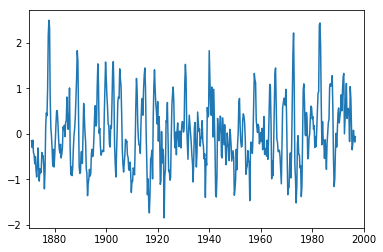

In [3]:
sst_nino3=np.loadtxt('data\sst_nino3.dat')
sst = sst_nino3
n=len(sst)
dt = 0.25 

time = np.arange(n)*dt + 1871.0   # construct time array
xlim = [1870,2000]  # plotting range

plt.plot(time,sst)
xrange=plt.xlim(xlim)

------------------------------------------------------ Computation

 Normalize by standard deviation (not necessary, but makes it easier to compare with plot on Interactive Wavelet page, at
 "http://paos.colorado.edu/research/wavelets/plot/" )



## 2. Wavelet Spectrum by Torrence and Compo [1998]

In [4]:
variance = np.std(sst)**2
mean=np.mean(sst)
sst = (sst - np.mean(sst))/np.sqrt(variance)
print "mean=",mean
print "std=", np.sqrt(variance)

mean= -1.98412698413e-05
std= 0.733599112824


__Set wavelet parameters__

In [5]:
pad = 1      # pad the time series with zeroes (recommended)
dj = 0.25    # this will do 4 sub-octaves per octave
s0 = 2.*dt    # this says start at a scale of 6 months
j1 = 7./dj    # this says do 7 powers-of-two with dj sub-octaves each
lag1 = 0.72  # lag-1 autocorrelation for red noise background
mother = 'Morlet'

__Wavelet transform__

In [6]:
wave,period,scale,coi = wavelet(sst,dt,pad,dj,s0,j1,mother);
power = (np.abs(wave))**2         # compute wavelet power spectrum

__Significance levels:__   
(variance=1 for the normalized SST)

In [7]:
signif,fft_theor = wave_signif(1.0,dt,scale,0,lag1,-1,-1,mother)
sig95 = np.dot(signif.reshape(len(signif),1),np.ones((1,n))) # expand signif --> (J+1)x(N) array
sig95 = power / sig95         # where ratio > 1, power is significant

__Global wavelet spectrum & significance levels__

In [8]:
global_ws = variance*power.sum(axis=1)/float(n)   # time-average over all times
dof = n - scale  # the -scale corrects for padding at edges
global_signif,fft_theor = wave_signif(variance,dt,scale,1,lag1,-1,dof,mother)

__Scale-average between El Nino periods of 2--8 years__

In [9]:
avg = (scale >= 2) & (scale < 8)
Cdelta = 0.776;   # this is for the MORLET wavelet
scale_avg = np.dot(scale.reshape(len(scale),1),np.ones((1,n))) # expand scale --> (J+1)x(N) array
scale_avg = power / scale_avg   # [Eqn(24)]
scale_avg = variance*dj*dt/Cdelta*sum(scale_avg[avg,:])   # [Eqn(24)]
scaleavg_signif ,fft_theor= wave_signif(variance,dt,scale,2,lag1,-1,[2,7.9],mother)

__Reconstuction__

Define inverse wavelet function base on Torrence and Compo [1998], eq. (11)
See list at the bottom of this note

In [10]:
from wavelet_inverse import wavelet_inverse

Reconstruct

In [11]:
iwave=wavelet_inverse(wave, scale, dt, dj, "Morlet")
print "root square mean error",np.sqrt(np.sum((sst-iwave)**2)/float(len(sst)))*np.sqrt(variance),"deg C"

root square mean error 0.0775581101677 deg C


__Plot__

Corresponding to Fig. 4 top in Liu et al. (2007)

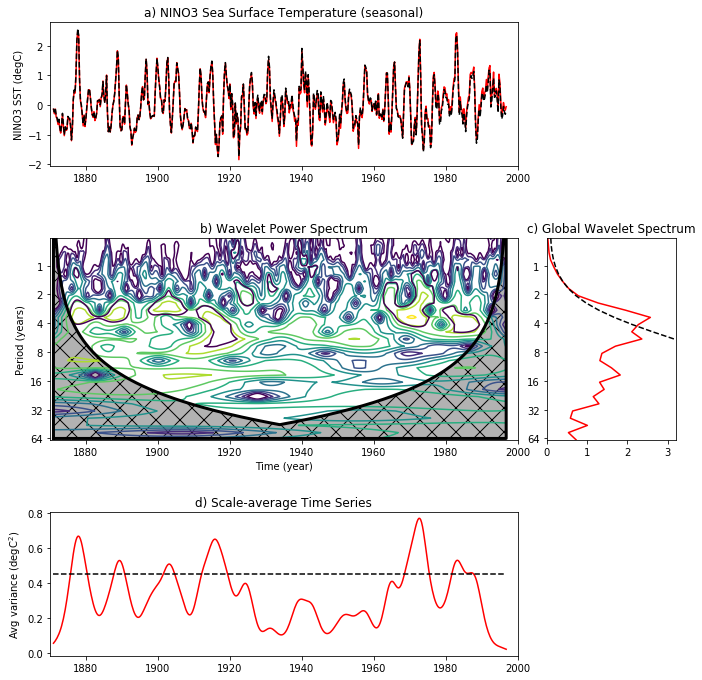

In [12]:
#figure size
fig=plt.figure(figsize=(10,10))

# subplot positions
width= 0.65
hight = 0.28;
pos1a = [0.1, 0.75, width, 0.2]
pos1b = [0.1, 0.37, width, hight]
pos1c = [0.79, 0.37, 0.18, hight]
pos1d = [0.1,  0.07, width, 0.2]

#########################################
#---- a) Original signal
#########################################
ax=fig.add_axes(pos1a)
#original
ax.plot(time,sst*np.sqrt(variance)+mean,"r-")
#reconstruction
ax.plot(time,iwave*np.sqrt(variance)+mean,"k--")

ax.set_ylabel('NINO3 SST (degC)')
plt.title('a) NINO3 Sea Surface Temperature (seasonal)')

#########################################
#   b) Wavelet spectrum
#########################################

#--- Contour plot wavelet power spectrum
bx=fig.add_axes(pos1b,sharex=ax)
levels = [0.0625,0.125,0.25,0.5,1,2,4,8,16] 
Yticks = 2**(np.arange(np.int(np.log2(np.min(period))),np.int(np.log2(np.max(period)))+1))
bx.contour(time,np.log2(period),np.log2(power),np.log2(levels))
bx.set_xlabel('Time (year)')
bx.set_ylabel('Period (years)')
import matplotlib.ticker as ticker
ymajorLocator=ticker.FixedLocator(np.log2(Yticks))
bx.yaxis.set_major_locator( ymajorLocator )
ticks=bx.yaxis.set_ticklabels(Yticks)
plt.title('b) Wavelet Power Spectrum')

# 95% significance contour, levels at -99 (fake) and 1 (95% signif)
cs = bx.contour(time,np.log2(period),sig95,[1],color='k',linewidth=1)

# cone-of-influence, anything "below" is dubious
ts = time;
coi_area = np.concatenate([[np.max(scale)], coi, [np.max(scale)],[np.max(scale)]])
ts_area = np.concatenate([[ts[0]], ts, [ts[-1]] ,[ts[0]]]);
L = bx.plot(ts_area,np.log2(coi_area),'k',linewidth=3)
F=bx.fill(ts_area,np.log2(coi_area),'k',alpha=0.3,hatch="x")

#########################################
#   c) Global Wavelet spectrum
#########################################

#--- Plot global wavelet spectrum
cx=fig.add_axes(pos1c,sharey=bx)
cx.plot(global_ws,np.log2(period),"r-")
cx.plot(global_signif,np.log2(period),'k--')
ylim=cx.set_ylim(np.log2([period.min(),period.max()]))
cx.invert_yaxis()
plt.title('c) Global Wavelet Spectrum')
xrangec=cx.set_xlim([0,1.25*np.max(global_ws)])

#########################################
#   d) Scale average Spectrum
#########################################
#--- Plot Scale-averaged spectrum -----------------
dx=fig.add_axes(pos1d,sharex=bx)
dx.plot(time,scale_avg,"r-")
dx.plot([time[0],time[-1]],[scaleavg_signif,scaleavg_signif],"k--")
xrange=dx.set_xlim(xlim)
dx.set_ylabel('Avg variance (degC$^2$)')
title=plt.title('d) Scale-average Time Series')
plt.savefig(r"image\nino3_TorrenceCompo.png")

## 3. Wavelet Spectrum by Liu et al [2007]

<span style="color:red">__Bias rectification__  </span>
  
divided by scales  

In [13]:
########################
#  Spectrum
########################
powers=np.zeros_like(power)
for k in range(len(scale)):
    powers[k,:] = power[k,:]/scale[k]
#significance: sig95 is already normalized = 1

########################
#  Spectrum
########################
global_wss = global_ws/scale   
global_signifs=global_signif/scale

########################
#  Scale-average between El Nino periods of 2--8 years
########################
# No need to change 
# because in Eqn(24) of Torrence and Compo [1998], division by scale has been done.
scale_avgs=scale_avg
scaleavg_signifs=scaleavg_signif

__Plot__  

Corresponding to Fig. 4 bottom in Liu et al. (2007)

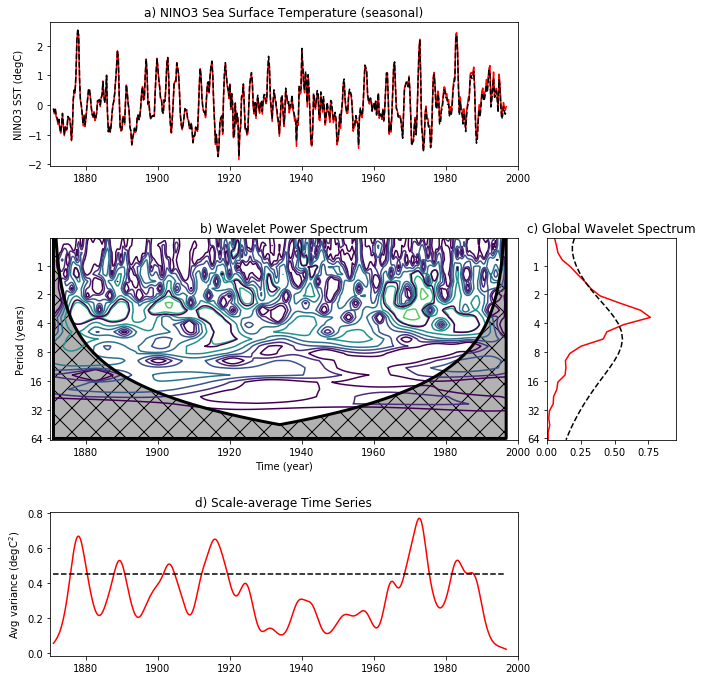

In [14]:
#figure size
fig=plt.figure(figsize=(10,10))

# subplot positions
width= 0.65
hight = 0.28;
pos1a = [0.1, 0.75, width, 0.2]
pos1b = [0.1, 0.37, width, hight]
pos1c = [0.79, 0.37, 0.18, hight]
pos1d = [0.1,  0.07, width, 0.2]

#########################################
#---- a) Original signal
#########################################
ax=fig.add_axes(pos1a)
#original
ax.plot(time,sst*np.sqrt(variance)+mean,"r-")
#reconstruction
ax.plot(time,iwave*np.sqrt(variance)+mean,"k--")

ax.set_ylabel('NINO3 SST (degC)')
plt.title('a) NINO3 Sea Surface Temperature (seasonal)')

#########################################
#   b) Wavelet spectrum
#########################################

#--- Contour plot wavelet power spectrum
bx=fig.add_axes(pos1b,sharex=ax)
levels = [0.0625,0.125,0.25,0.5,1,2,4,8,16] 
Yticks = 2**(np.arange(np.int(np.log2(np.min(period))),np.int(np.log2(np.max(period)))+1))
bx.contour(time,np.log2(period),np.log2(powers),np.log2(levels))
bx.set_xlabel('Time (year)')
bx.set_ylabel('Period (years)')
import matplotlib.ticker as ticker
ymajorLocator=ticker.FixedLocator(np.log2(Yticks))
bx.yaxis.set_major_locator( ymajorLocator )
ticks=bx.yaxis.set_ticklabels(Yticks)
plt.title('b) Wavelet Power Spectrum')

# 95% significance contour, levels at -99 (fake) and 1 (95% signif)
cs = bx.contour(time,np.log2(period),sig95,[1],color='k',linewidth=1)

# cone-of-influence, anything "below" is dubious
ts = time;
coi_area = np.concatenate([[np.max(scale)], coi, [np.max(scale)],[np.max(scale)]])
ts_area = np.concatenate([[ts[0]], ts, [ts[-1]] ,[ts[0]]]);
L = bx.plot(ts_area,np.log2(coi_area),'k',linewidth=3)
F=bx.fill(ts_area,np.log2(coi_area),'k',alpha=0.3,hatch="x")

#########################################
#   c) Global Wavelet spectrum
#########################################

#--- Plot global wavelet spectrum
cx=fig.add_axes(pos1c,sharey=bx)
cx.plot(global_wss,np.log2(period),"r-")
cx.plot(global_signifs,np.log2(period),'k--')
ylim=cx.set_ylim(np.log2([period.min(),period.max()]))
cx.invert_yaxis()
plt.title('c) Global Wavelet Spectrum')
xrangec=cx.set_xlim([0,1.25*np.max(global_wss)])

#########################################
#   d) Global Wavelet spectrum
#########################################
#--- Plot Scale-averaged spectrum -----------------
dx=fig.add_axes(pos1d,sharex=bx)
dx.plot(time,scale_avgs,"r-")
dx.plot([time[0],time[-1]],[scaleavg_signifs,scaleavg_signifs],"k--")
xrange=dx.set_xlim(xlim)
dx.set_ylabel('Avg variance (degC$^2$)')
title=plt.title('d) Scale-average Time Series')
plt.savefig(r"image\nino3_liu.png")

__References:__  
  
* Liu, Y., X.S. Liang, and R.H. Weisberg, 2007: Rectification of the bias in the wavelet power spectrum. Journal of Atmospheric and Oceanic Technology, 24(12), 2093-2102. http://ocgweb.marine.usf.edu/~liu/wavelet.html
   
* Torrence, C., and G. P. Compo, 1998: A practical guide to wavelet analysis. Bull. Amer. Meteor. Soc., 79, 6178. http://paos.colorado.edu/research/wavelets/ 